#### Plotting Distances between Correlation Coefficients per Sample

The Pearson correlation coefficient was used in this pipeline. This is because we are trying to confirm a direct relationship between the two replicates. This allows us to check if enrichment levels are strong & consistent across both replicates at specific loci, rather than ranking individual regions and comparing the rankings. Because this pipeline is analyzing continuous data that models a direct relationship, the Spearman coefficient is likely not the best choice.

#### Consensus Set of Peaks
Only peaks from the first sample that overlap at minimum 50% with peaks from the second sample are included. This ensures that only peaks identified in both a moderate number of times are included while still filtering out signals specific to a single sample

#### Removing Blacklisted Regions
I removed any entries in the BED that overlap by at least 1 bp in the blacklisted BED. This removes any problematic genomic regions which can increase confidence in the output.

#### Plot Profile
![img](../results/input_group_signal_coverage.png)

The figure shows the average read coverage from the two samples across the hg38 Human genome. The Deeptools computeMatrix tool was used with 2000 bp of padding for each gene. Both samples have an enriched signal around the transcription start site suggesting activity at promoter regions. These samples exhibit the expected behavior as they peak near the TSS, experience a sharp decline afterwards, and stagnate after the transcription end site.

#### Finding Enriched Motifs in ChIP-seq Peaks

In [2]:
import pandas as pd

# load from results
motif_df = pd.read_csv("results/motifs/knownResults.txt", sep='\t')

# top 10 enriched motifs
motif_df.head(10)

,Motif Name,Consensus,P-value,Log P-value,q-value (Benjamini),# of Target Sequences with Motif(of 3026),% of Target Sequences with Motif,# of Background Sequences with Motif(of 43414),% of Background Sequences with Motif
0,RUNX(Runt)/HPC7-Runx1-ChIP-Seq(GSE22178)/Homer,SAAACCACAG,0.000000e+00,-965.7,0.0,923.0,30.50%,2309.6,5.32%
1,RUNX1(Runt)/Jurkat-RUNX1-ChIP-Seq(GSE29180)/Homer,AAACCACARM,1.000000e-310,-715.2,0.0,925.0,30.57%,3195.7,7.36%
2,RUNX2(Runt)/PCa-RUNX2-ChIP-Seq(GSE33889)/Homer,NWAACCACADNN,1.000000e-204,-470.6,0.0,704.0,23.27%,2681.9,6.18%
3,RUNX-AML(Runt)/CD4+-PolII-ChIP-Seq(Barski_et_a...,GCTGTGGTTW,1.000000e-196,-453.5,0.0,648.0,21.41%,2353.0,5.42%
4,Foxa2(Forkhead)/Liver-Foxa2-ChIP-Seq(GSE25694)...,CYTGTTTACWYW,1.000000e-93,-214.7,0.0,387.0,12.79%,1647.9,3.80%
5,FOXA1(Forkhead)/LNCAP-FOXA1-ChIP-Seq(GSE27824)...,WAAGTAAACA,1.000000e-86,-199.3,0.0,474.0,15.66%,2462.4,5.67%
6,Fosl2(bZIP)/3T3L1-Fosl2-ChIP-Seq(GSE56872)/Homer,NATGASTCABNN,1.000000e-86,-199.1,0.0,241.0,7.96%,712.1,1.64%
7,Fra2(bZIP)/Striatum-Fra2-ChIP-Seq(GSE43429)/Homer,GGATGACTCATC,1.000000e-85,-195.9,0.0,283.0,9.35%,994.4,2.29%
8,GRHL2(CP2)/HBE-GRHL2-ChIP-Seq(GSE46194)/Homer,AAACYKGTTWDACMRGTTTB,1.000000e-84,-194.4,0.0,270.0,8.92%,914.5,2.11%
9,FOXA1(Forkhead)/MCF7-FOXA1-ChIP-Seq(GSE26831)/...,WAAGTAAACA,1.000000e-82,-190.1,0.0,412.0,13.62%,2004.0,4.62%


This analysis revealed primarily the RUNX and FOXA motif families at the top of the enriched motifs. The RUNX motif family has exhibited extremely low p-values and are present in 20-30% of the sequences, suggesting a strong enrichment. Similarly, the FOXA family has low p-values and are present in 12-15% of the sequences. The original sample was likely encoding some DNA-protein interactions and transcription regulators. 

#### Methods

In this study, a reproducible ChIPseq pipeline using NextFlow (v24.04.2) to process & analyze raw sequencing reads was developed. The pipeline handles read processing, quality control, alignment, peak calling, and functional annotation. Each tool in this pipeline was containerized using images hosted on the Boston University BF528 Container Registry on GitHub. 

Raw paired-end sequences obtained from a ChIPseq experiment underwent quality assessment with FastQC. Subsequently quality control (including trimming of adapter sequences, low-quality bases, and below average regions) was performed with Trimmomatic (v0.39). Reads were trimmed using the IlluminaClip function (2:3:10), with 3 leading/trailing nt clipped, and a sliding window of 4:15. A Bowtie2 (2.5.4) index was generated using the GRCh38 reference genome and the cleaned reads were mapped to the index using Bowtie2. The results of Samtools (v1.21) flagstat on the alignment was aggregated with the FastQC results to generate a comprehensive quality assessment report with MultiQC (v1.25). The aligned dataset was then sorted & indexed with Samtools. Deeptools (v3.5.5) was used for downstream analysis. Coverage signals were then calculated for each replicate using Deeptools BamCoverage to transform BED inputs to normalized BigWig files and compared using Deeptools MultiBigWigSummary. The Spearman correlation coefficient was also calculated to assess the similarity between the replicates and visualized using Deeptools plotCorrelation. Peak calling was performed with MACS3 (v3.0.2) to identify significant regions in the sequencing data with otherwise default parameters. The peak files were processed using primarily Bedtools (v2.31.1). The peak files were intersected with the bedtools intersect tool to isolate peaks that are duplicated in both replicates at least 50% of the time. Peaks overlapping any blacklisted regions with a 0 bp tolerance were also removed. The blacklist was generated by the Boston University Boyle Lab as a part of the ENCODE project. The filtered peaks were annotated and analyzed using Homer (v4.11). Specifically, filtered peaks were annotated using Homer annotatePeaks.pl using the GRCh38 GTF to determine the distribution of reads. Homer findMotifsGenome.pl with parameters of size = 200 and mask was used to perform a motif enrichment analysis against the masked GRCh38 reference. The top 10 enriched motifs were extracted from the findMotifsGenome.pl results. ChIP signals were visualized by first passing IP samples to Deeptools computeMatrix in scale-regions mode against GRCh38 with 2000 bp padding on either end of the gene. This matrix was visualized using Deeptools plotProfile to produce a plot of read density across genes in the reference genome. 

#### MultiQC Report
The ChIPseq reads showed overall high quality, across both replicates. Phred scores for base quality were consistently > 30 indicating high mean base quality. Similarly, Phred scores for sequence quality were also consistently > 30, indicating high individual sequence quality. Furthermore, any low quality regions and adapter contamination was trimmed by Trimmomatic. These metrics confirm that the ChIPseq dataset is of good quality and will produce reliable downstream analyses. 

#### Recreated Figure 2F

![img](../results/figure_2c.png)

In the recreated figure 2F, there was a noticeably smaller number of genes that were both differentially expressed and tied to the RUNX1 transcription factor compared to the original figure. Differences in the workflow & analyses on the same raw ChIP-seq reads is likely what caused this disagreement. This pipeline required 50% of peaks to overlap across replicates. This threshold could be more strict than what was originally used. There could also be discrepancies in the peak annotation method between the original study and this replication. This pipeline used MACS3 to identify and call peaks whereas the original study used the HOMER suite for both peak calling and annotation. Additionally, by looking at both ChIPseq data and RNAseq data, it is much easier to identify direct targets of the RUNX1 transcription factor (genes where ChIPseq peaks and RNAseq shows it is differentially expressed).

#### Recreated Figure 2D (MALAT1)
![img](../results/figure_2d.png)

#### Recreated Figure 2E (NEAT1)
![img](../results/figure_2e.png)

There was a strong ChIPseq signal enrichment evidenced by the peaks across the IP replicates overlapping the MALAT1 gene. The signal peaks that were identified also aligned with the output of the peak calling technique employed in this pipeline, even after extensive filtering. This was less apparent for the NEAT1 mapping but the IP replicates were relatively overlapped. However, the genomic tracks here appear different to the tones highlighted in the original publication as there are still differences in peak height and distribution. Futhermore, the tool used in this scenario, IGV (v2.19.3), identified the MALAT1 and NEAT1 genes at different chromosomal coordinates compared to the original study. That is likely where a majority of the difference is coming from. 

#### Figure S2A

In [ ]:
import pandas as pd
import os
import gzip
import re

# Load the sample sheet
samples_df = pd.read_csv("../full_samplesheet.csv")

# flagstat results directory
flagstat_dir = "../results/"

# initialize output list
records = []

# sample type renaming map
name_map = {
    "IP": "RUNX1 ChIP",
    "INPUT": "INPUT"
}

# each sample
for _, row in samples_df.iterrows():
    sample = row["name"]
    fastq_path = row["path"]
    flagstat_path = os.path.join(flagstat_dir, f"{sample}_flagstat.txt")

    # extract type and replicate number
    match = re.match(r"(IP|INPUT)_rep(\d+)", sample)
    if not match:
        continue
    sample_type_key, replicate = match.groups()
    sample_type = name_map.get(sample_type_key, sample_type_key)

    # count raw reads from .fastq.gz
    with gzip.open(fastq_path, "rt") as fq:
        raw_reads = sum(1 for _ in fq) // 4

    # extract mapped reads
    mapped_reads = None
    with open(flagstat_path, "r") as f:
        for line in f:
            if " mapped (" in line and "primary" not in line:
                mapped_reads = int(line.strip().split()[0])
                break

    records.append({
        "Sample Name": sample_type,
        "Biological Replicate": int(replicate),
        "Raw Reads": raw_reads,
        "Mapped Reads": mapped_reads
    })

In [11]:
# Create DataFrame and format
df = pd.DataFrame(records)
df = df.sort_values(by=["Sample Name", "Biological Replicate"])
df["Raw Reads"] = df["Raw Reads"].apply(lambda x: f"{x:,}")
df["Mapped Reads"] = df["Mapped Reads"].apply(lambda x: f"{x:,}")

# Display the table
df.reset_index(drop=True, inplace=True)
print(df)

  Sample Name  Biological Replicate   Raw Reads Mapped Reads
0       INPUT                     1  30,075,142   28,870,437
1       INPUT                     2  10,900,442   10,189,399
2  RUNX1 ChIP                     1  29,734,121   28,098,601
3  RUNX1 ChIP                     2  29,988,988   28,468,440


The raw read counts are the same as in the original study (the ChIPseq data was obtained from this study) but the mapped reads are slightly different. This discrepancy could be caused by a difference in data pre-prcessing techniques. This pipeline performed adapter trimming & quality control using a set of defined trimming criteria (leading/trailing 3-mers are trimmed with a sliding window of 4:15). The original pipeline like employed a stricter set of criteria which resulted in less mapped reads. The original pipeline could have also filtered out more reads during the processing stage. This pipeline includes all primary mapped reads in its analysis and never filters out things such as PCR duplicates, which also might not have been done in the original pipeline.

#### Figure S2B for this pipeline

![img](../results/pearson_plot.png)

There was a minute discrepancy in the Pearson Correlation plot generated by this pipeline and the workflow detailed in the original study. The exact correlation coefficients differ, likely due to differences in peak calling thresholds, quality control parameters, etc. Regardless, the authors of the original paper likely used this plot to confirm that their dataset was reliable & reproducible. The input samples correlated strongly with each other, indicating that the background signal is consistent, while the RUNX1 samples do not correlate as strongly. This indicates that the ChIPseq signal is specific to the library rather than just background noise. Both figures show that the experiment worked well and captured real DNA binding sites. 

#### Figure S2C

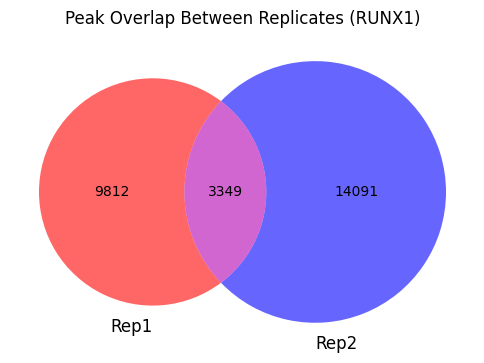

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# count lines in the BED files
def count_lines(filepath):
    with open(filepath) as f:
        return sum(1 for _ in f)

# paths to your BED files
rep1_path = "../rep1_peaks.bed"
rep2_path = "../rep2_peaks.bed"
overlap_path = "../results/repr_peaks.bed"

# get counts
rep1_total = count_lines(rep1_path)
rep2_total = count_lines(rep2_path)
overlap = count_lines(overlap_path)

# unique values
only_rep1 = rep1_total - overlap
only_rep2 = rep2_total - overlap

# plot
plt.figure(figsize=(6, 6))
venn2(subsets=(only_rep1, only_rep2, overlap),
      set_labels=('Rep1', 'Rep2'),
      set_colors=('red', 'blue'),
      alpha=0.6)

plt.title("Peak Overlap Between Replicates (RUNX1)")
plt.show()


The results from thie peak analysis shows 3349 shared peaks between the two replicates, compared to 3466 reported by the original study. The replicates here reported a higher number of unique peaks than reported in the original study. One reason this could have happened is discrepancies in peak calling parameters. This pipeline used MACS3 to identify and call peaks whereas the original study used the HOMER suite for both peak calling and annotation. Another factor is the difference in read depth these replicates had more mapped reads than those in the original study, potentially resulting in additional weak peaks being called that were filtered out in the original analysis.

In [ ]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

# annotated peaks file
annot = pd.read_csv("../results/annotated_peaks.txt", sep="\t", comment='#')

# Drop NA gene names and get unique ones 
genes = annot['Gene Name'].dropna().unique().tolist()

# Run enrichment (you can also use 'KEGG_2021_Human', 'GO_Molecular_Function_2021', etc.)
enr = gp.enrichr(gene_list=genes,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human',
                 outdir=None,  # don't write to disk
                 cutoff=0.05   # Adjusted p-value threshold
                )

# top 10 enriched terms as a barplot
gp.barplot(enr.results.head(10), 
           title='Top 10 GO:BP Enriched Terms',
           figsize=(6,5))
plt.tight_layout()
plt.show()

enr.results.head(10)


Exception: Error sending gene list, try again later

Gene set enrichment analysis with GSEApy, a python-based interface for Enrichr, was used to investigate biological functions associated with the RUNX-1 bound regions. The analysis started with a simple text file containing genomic regions annotated with gene names and other spatial information. This gene list was filtered to only include unique genes and submitted to Enrichr using the GO:BP 2021 gene set at an adjusted p-value threshold of 0.05 to filter for significant enrichments. The top 10 enriched biological pathways were then visualized with a boxplot, highlighting key biological pathways that are potentially regulated by the RUNX1 transcription factor in this dataset. 